In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
train = pd.read_csv('train.csv').fillna(' ').sample(frac=1)
train.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
147393,3baf9aa06cfc9da4,"""\n\n Condemn all you want, the article was d...",0,0,0,0,0,0
48099,80857fbe9a005d0f,File:IMG 0037.JPG.JPG listed for deletion \nA ...,0,0,0,0,0,0
89371,ef120a4e21082237,unban unban unban unban unban unban unban unba...,0,0,0,0,0,0


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159571 entries, 147393 to 140390
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 11.0+ MB


this time looking for common toxicity. If comment hits 1 in any of toxic class we would label it as toxic.

In [4]:
class_names = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

In [5]:
train['y'] = train[class_names].max(axis=1).values
train['y'].value_counts()

0    143346
1     16225
Name: y, dtype: int64

16225 comments in our dataset is toxic

Splitting dataset

In [6]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('y', 1), train['y'],random_state=0)

C:\Users\Антон\AppData\Local\Temp\ipykernel_48992\2981903438.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train, X_test, y_train, y_test = train_test_split(train.drop('y', 1), train['y'],random_state=0)


let`s look on distribution of comments in subsets:

In [7]:
y_train.value_counts(normalize=True)

0    0.899062
1    0.100938
Name: y, dtype: float64

In [8]:
y_test.value_counts(normalize=True)

0    0.896097
1    0.103903
Name: y, dtype: float64

seems like dataset pretty even

Let`s transform text to vector form and train logistic regression

building simple pipeline with a class for picking Features

In [9]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.column]
    
classifier = Pipeline([('comment_text_selector', FeatureSelector(column='comment_text')),
                      ('comment_text_tfidf', TfidfVectorizer(sublinear_tf=True,
                                                           strip_accents='unicode',
                                                           analyzer='word',
                                                           token_pattern=r'\w{1,}',
                                                           stop_words='english',
                                                           ngram_range=(1,1),
                                                           max_features=10000)),
                       ('clf',LogisticRegression(C=0.1, solver='sag'))])
# starting cross-validation
cv_scores = cross_val_score(classifier, X_train, y_train, cv=3, scoring='roc_auc')
cv_score = np.mean(cv_scores)
print(f'CV score is {cv_score}')
# learnin pipeline on the whole train dataset
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:,1]


CV score is 0.9559504232059904


let`s use sklearn to find optimal threshold

In [10]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

In [11]:
b=2.55

precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
#locate the index of the largest f-score
ix = np.argmax(fscore)
print('best Threshold=%f, F-score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix],
                                                                       fscore[ix],
                                                                       precision[ix],
                                                                       recall[ix]))

best Threshold=0.110761, F-score=0.805, Precision=0.499, Recall=0.889


let`s plot roc curve

In [12]:
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

%matplotlib inline

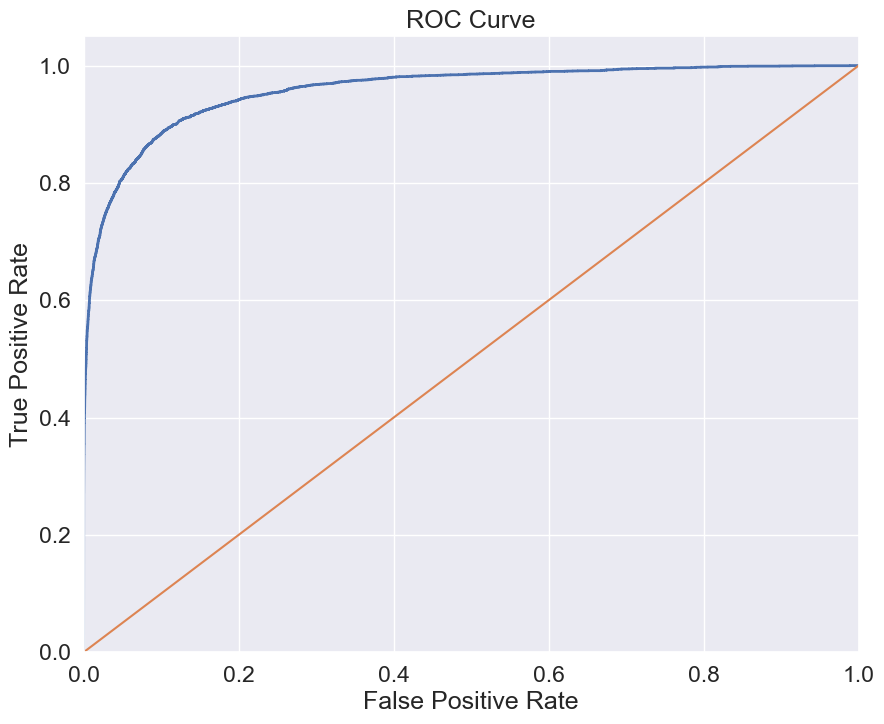

In [13]:
sns.set(font_scale=1.5)
sns.set_color_codes('muted')
plt.figure(figsize=(10,8))

fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve')
plt.plot([0,1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [18]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix without normalization')
    
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center',
                 color = 'white' if cm[i, j] > thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix without normalization
[[32042  3706]
 [  460  3685]]


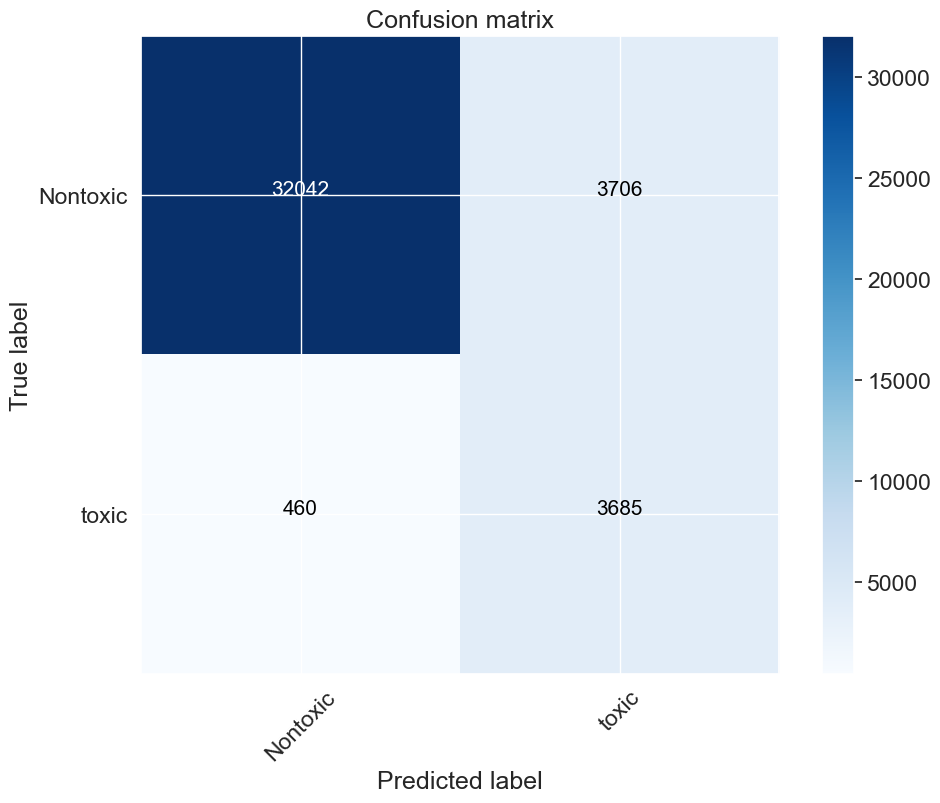

In [19]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Nontoxic', 'toxic'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Посчитаем TPR, FPR

In [21]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]
print(f'TN:{TN}\nFN:{FN}\nTP:{TP}\nFP:{FP}')

TN:32042
FN:460
TP:3685
FP:3706


Вычислим метрики

In [27]:
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
print(f'TPR:{TPR:.3f}\nFPR:{FPR:.3f}\nTNR:{TNR:.3f}')

TPR:0.889
FPR:0.104
TNR:0.896


FPR 0.104 означает, что лишь 10.4% некорректно помечены как токсичные, 
88.9% - модель размечает корректно.

TNR = 89.6% говорит о том, что около 90% токсичных сообщений модель фильтрует корректно